In [1]:
# export full genome
from pybedtools import genome_registry, chromsizes_to_file, chromsizes
chromsizes_to_file(chromsizes('hg19'), '../download/genome/hg19.genome')

'../download/genome/hg19.genome'

In [2]:
assembly_path = "../download/genome/hg19_reduced.genome"

In [3]:
import pandas as pd
import numpy as np
from pybedtools import BedTool

In [11]:
fantom_bed = BedTool("../download/FANTOM/permissive_enhancers.bed")

In [10]:
repeat_bed_df = pd.read_hdf("../storage/repeatmasker_staging.hdf", "SINE_MIR_bed")
repeat_bed = BedTool().from_dataframe(repeat_bed_df)

In [12]:
fantom_bed.head()

chr1	858256	858648	chr1:858256-858648	5	.	858447	858448	0,0,0	2	1,10	0,382
 chr1	918449	918555	chr1:918449-918555	18	.	918504	918505	0,0,0	2	7,1	0,105
 chr1	941791	942135	chr1:941791-942135	2	.	942081	942082	0,0,0	2	238,1	0,343
 chr1	945769	946034	chr1:945769-946034	17	.	945889	945890	0,0,0	2	1,25	0,240
 chr1	956563	956812	chr1:956563-956812	143	.	956664	956665	0,0,0	2	57,102	0,147
 chr1	1005293	1005547	chr1:1005293-1005547	66	.	1005420	1005421	0,0,0	2	57,55	0,199
 chr1	1014834	1015095	chr1:1014834-1015095	17	.	1014858	1014859	0,0,0	2	1,213	0,48
 chr1	1060905	1061095	chr1:1060905-1061095	7	.	1060999	1061000	0,0,0	2	1,1	0,189
 chr1	1063914	1064111	chr1:1063914-1064111	50	.	1063978	1063979	0,0,0	2	45,112	0,85
 chr1	1093610	1093958	chr1:1093610-1093958	7	.	1093953	1093954	0,0,0	2	341,1	0,347
 

In [13]:
fantom_bed.count()

43011

In [14]:
repeat_bed.count()

594372

In [15]:
encode_bed_df = fantom_bed.to_dataframe()

## MIR-enhancers: core of enhancers in MIR

In [16]:
def compute_centers(df):
    df['centered_locus'] = round(
        (df['end'] - df['start'])/2 
        + df['start']).astype(int)

In [17]:
compute_centers(encode_bed_df)

In [18]:
encode_bed_cores_df = encode_bed_df.copy()
encode_bed_cores_df['start'] = encode_bed_cores_df['centered_locus']
encode_bed_cores_df['end'] = encode_bed_cores_df['centered_locus']

In [19]:
encode_bed_cores = BedTool().from_dataframe(encode_bed_cores_df[['chrom', 'start', 'end', 'name', 'score', 'strand']])

In [20]:
encode_bed_cores.count()

43011

In [21]:
#MIR-enhancers: core of enhancer in MIR
core_intersection = encode_bed_cores.intersect(repeat_bed)

In [22]:
core_intersection.count()

1406

In [23]:
core_intersection.head()

chr1	6779848	6779848	chr1:6779783-6779914	2	.
 chr1	8720604	8720604	chr1:8720526-8720683	19	.
 chr1	9271636	9271636	chr1:9271499-9271772	4	.
 chr1	12235266	12235266	chr1:12235070-12235463	42	.
 chr1	12533545	12533545	chr1:12533412-12533678	3	.
 chr1	14028126	14028126	chr1:14027926-14028325	157	.
 chr1	15664381	15664381	chr1:15664307-15664455	16	.
 chr1	19264144	19264144	chr1:19264079-19264209	4	.
 chr1	19803508	19803508	chr1:19803336-19803680	10	.
 chr1	21665045	21665045	chr1:21664947-21665143	60	.
 

In [24]:
# null model MIR-enhancers
shuffled_encode_bed_cores = encode_bed_cores.shuffle(g=assembly_path)
core_null_model_intersection = shuffled_encode_bed_cores.intersect(repeat_bed)

In [25]:
core_null_model_intersection.count()

1239

In [26]:
def compute_size(row, prefix=None):
    col_name = prefix + '_name' if prefix else 'name'
    if row[col_name] == '.':
        return 0
    col_end = prefix + '_end' if prefix else 'end'
    col_start = prefix + '_start' if prefix else 'start'
    size = abs(row[col_end] - row[col_start])
    return size

def mean_size(bed):
    sample_df = bed.to_dataframe()
    sample_df['size'] = sample_df.apply(lambda row: compute_size(row), axis=1)
    return int(round(sample_df[['size']].mean()))

def build_random_overlap(bed, intervals_size, intervals_num, min_overlap, assembly, df_columns, idx):
    empty_bed = BedTool()
    random_bed = empty_bed.random(l=intervals_size, n=intervals_num,
                                  g=assembly)
    row_array = [idx, bed.intersect(random_bed, f=min_overlap).count()]
    return pd.DataFrame([row_array], columns=df_columns)

def build_shuffled_overlap(bed, bed_overlap_with, min_overlap, assembly, df_columns, idx):
    random_bed = bed_overlap_with.shuffle(g=assembly, chrom=False)
    row_array = [idx, bed.intersect(random_bed, f=min_overlap).count()]
    return pd.DataFrame([row_array], columns=df_columns)

In [27]:
from joblib import Parallel, delayed
import multiprocessing

def create_random_overlap_distribution_parallelized(bed, bed_overlap_with, assembly, min_overlap, 
                                                    samples_num,strategy='random'):
    num_cores = multiprocessing.cpu_count()

    intervals_size = mean_size(bed_overlap_with)
    intervals_num = bed_overlap_with.count()
    columns = ['sample_num', 'size']

    if strategy == 'shuffle':
        df_list = Parallel(n_jobs=num_cores)(delayed(build_shuffled_overlap)
                                             (bed, bed_overlap_with, min_overlap, assembly, columns, i)
                                             for i in range(0, samples_num))
    else:
        df_list = Parallel(n_jobs=num_cores)(delayed(build_random_overlap)
                                             (bed, intervals_size, intervals_num, min_overlap, assembly, columns, i)
                                             for i in range(0, samples_num))
    return pd.concat(df_list)

In [28]:
test_df = create_random_overlap_distribution_parallelized(encode_bed_cores, repeat_bed, assembly_path,
                                                         1e-09, 100)

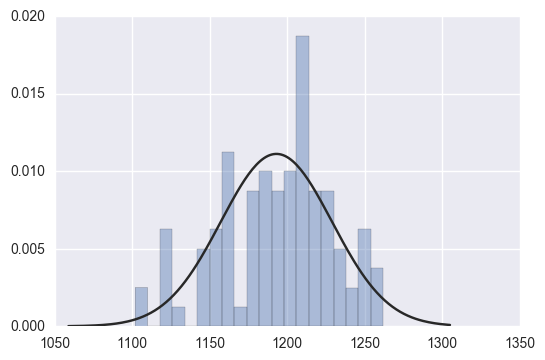

In [29]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(test_df[['size']], kde=False, fit=st.norm, bins=20)

In [30]:
z_score =(core_intersection.count() - np.mean(test_df['size']))/np.std(test_df['size'])
print(z_score)

5.934349112561755


In [31]:
import scipy.stats as st
st.norm.ppf(.95)
st.norm.cdf(z_score)

0.99999999852493249

In [32]:
p_values = st.norm.sf(abs(z_score))
p_values

1.4750674827082326e-09

In [33]:
st.ttest_1samp(a= test_df[['size']], popmean= core_intersection.count())

Ttest_1sampResult(statistic=array([-59.04602814]), pvalue=array([  5.53494921e-79]))

In [34]:
st.ttest_1samp(a= test_df[['size']], popmean= np.mean(test_df[['size']]))

Ttest_1sampResult(statistic=size    0.0
dtype: float64, pvalue=array([ 1.]))

In [35]:
chi2, p = st.chisquare( test_df[['size']],core_intersection.count() )
msg = "Test Statistic: {}\np-value: {}"
print( msg.format( chi2, p ) )

Test Statistic: [ 3315.01493599]
p-value: [ 0.]


In [36]:
encode_bed_cores.sort().fisher(repeat_bed.sort(), f=1e-09, g=assembly_path)

<FisherOutput at 4872620520>
# Number of query intervals: 43011
# Number of db intervals: 594327
# Number of overlaps: 1406
# Number of possible intervals (estimated): 21125242
# phyper(1406 - 1, 43011, 21125242 - 43011, 594327, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 1406         | 41605        |
# not in -a | 592921       | 20489310     |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	1.2728e-08	2.2459e-08	1.168

In [37]:
1-st.hypergeom.cdf(975, 21123880 - 33082, 33082, 593161)

0.067519672328844149

In [38]:
df_reldist = pd.DataFrame(encode_bed_cores.sort().reldist(repeat_bed.sort()))
df_reldist.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,888.000,837.000,860.00,869.00,918.000,828.000,891.000,889.000,888.000,927.000,...,819.000,869.00,795.000,852.00,820.000,822.000,835.000,860.00,843.00,6.0
fraction,0.021,0.019,0.02,0.02,0.021,0.019,0.021,0.021,0.021,0.022,...,0.019,0.02,0.018,0.02,0.019,0.019,0.019,0.02,0.02,0.0
reldist,0.000,0.010,0.02,0.03,0.040,0.050,0.060,0.070,0.080,0.090,...,0.410,0.42,0.430,0.44,0.450,0.460,0.470,0.48,0.49,0.5
total,43010.000,43010.000,43010.00,43010.00,43010.000,43010.000,43010.000,43010.000,43010.000,43010.000,...,43010.000,43010.00,43010.000,43010.00,43010.000,43010.000,43010.000,43010.00,43010.00,43010.0


In [39]:
df_reldist_random = pd.DataFrame(encode_bed_cores.sort().reldist(repeat_bed.shuffle(g=assembly_path, chrom=False).sort()))

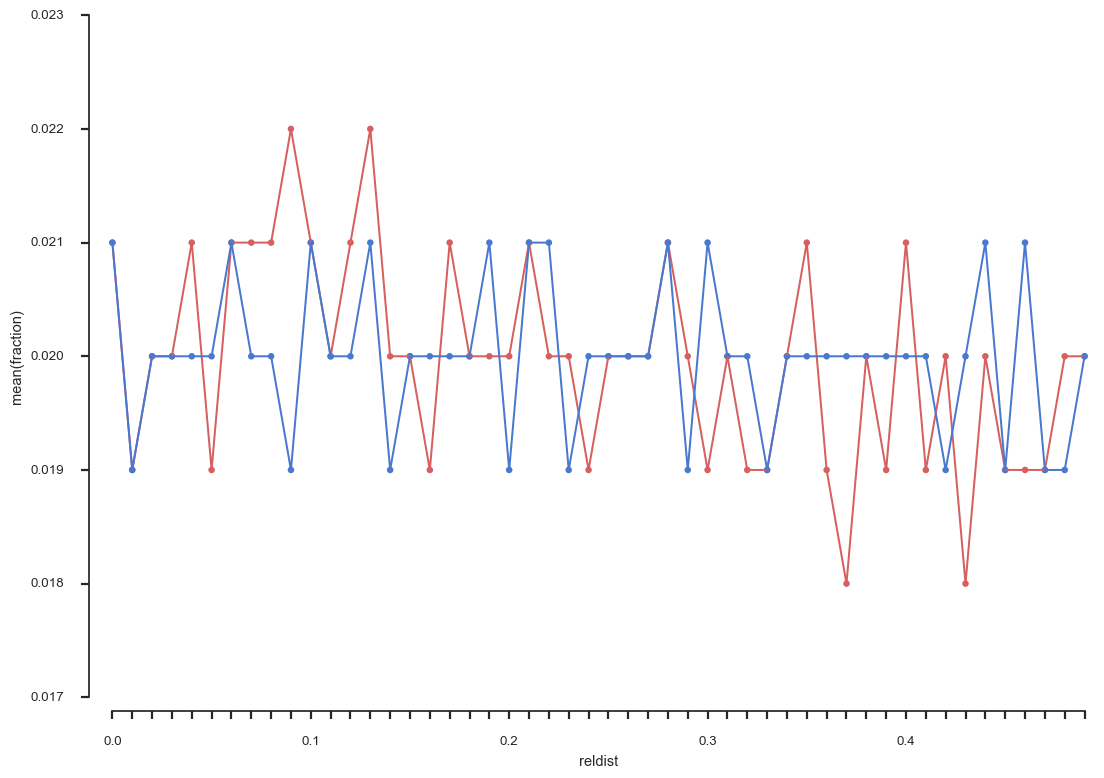

In [40]:
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="ticks", palette="muted", color_codes=True)
sns.set_context("poster", font_scale=0.6, rc={"lines.linewidth": 0.8})

g1 = sns.pointplot(x='reldist', y='fraction', data=df_reldist[0:50],  color='r')
g2 = sns.pointplot(x='reldist', y='fraction', data=df_reldist_random[0:50], color='b')

sns.despine(offset=10, trim=True)
#plot.set_yscale("log")
#df_reldist[['reldist','fraction']].plot()
for ind, label in enumerate(g1.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## Enhancer-MIRs: MIRs in a +/- 4 kbp window around enhancer's core 

In [41]:
encode_bed_df = fantom_bed.to_dataframe()
encode_bed_df['size'] = encode_bed_df.apply(lambda row: compute_size(row), axis=1)

In [42]:
encode_bed_df['size'].quantile(0.5) == encode_bed_df['size'].median()

True

In [43]:
encode_bed_df['size'].std()

163.37426764008453

/Users/manuel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


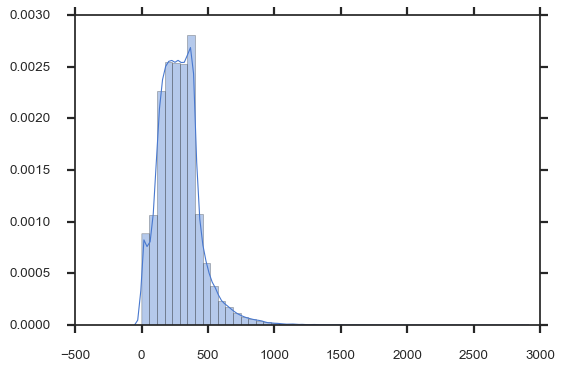

In [44]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(encode_bed_df[['size']], kde=True)

In [45]:
np.percentile(encode_bed_df[['size']], 50)

275.0

In [46]:
np.arange(0, 1, 0.1)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])

In [47]:
encode_bed_df[['size']].quantile(np.arange(0,1,0.1))

,size
0.0,2.0
0.1,109.0
0.2,157.0
0.3,197.0
0.4,236.0
0.5,275.0
0.6,315.0
0.7,354.0
0.8,390.0
0.9,462.0


In [ ]:
# what if using percentiles in considering enhancer regions? Eg: b=170/2, 251/2, ..., 3123/2
#encode_bed_slop = encode_bed_cores.slop(genome='hg19', b=int(round(3123/2)))

In [70]:
#compute "enhancers regions" as +/- 4kb from enhancer cores
encode_bed_slop = encode_bed_cores.slop(g=assembly_path, b=500)

In [71]:
encode_bed_cores.sort().head()

chr1	858452	858452	chr1:858256-858648	5	.
 chr1	918502	918502	chr1:918449-918555	18	.
 chr1	941963	941963	chr1:941791-942135	2	.
 chr1	945902	945902	chr1:945769-946034	17	.
 chr1	956688	956688	chr1:956563-956812	143	.
 chr1	1005420	1005420	chr1:1005293-1005547	66	.
 chr1	1014964	1014964	chr1:1014834-1015095	17	.
 chr1	1061000	1061000	chr1:1060905-1061095	7	.
 chr1	1064012	1064012	chr1:1063914-1064111	50	.
 chr1	1093784	1093784	chr1:1093610-1093958	7	.
 

In [72]:
encode_bed_slop.sort().head()

chr1	857952	858952	chr1:858256-858648	5	.
 chr1	918002	919002	chr1:918449-918555	18	.
 chr1	941463	942463	chr1:941791-942135	2	.
 chr1	945402	946402	chr1:945769-946034	17	.
 chr1	956188	957188	chr1:956563-956812	143	.
 chr1	1004920	1005920	chr1:1005293-1005547	66	.
 chr1	1014464	1015464	chr1:1014834-1015095	17	.
 chr1	1060500	1061500	chr1:1060905-1061095	7	.
 chr1	1063512	1064512	chr1:1063914-1064111	50	.
 chr1	1093284	1094284	chr1:1093610-1093958	7	.
 

In [73]:
encode_bed_slop.count()

43011

In [74]:
#enhancer-MIRs: MIR in +/- 4kb from the core of an enhancer 
#(asking the full MIR to be overlapped by an enhancer region)
region_intersection = repeat_bed.intersect(encode_bed_slop, f=1)

In [75]:
region_intersection.count()

10143

In [76]:
# null model enhancers-MIRs
shuffled_repeat = repeat_bed.shuffle(g=assembly_path)

In [77]:
shuffled_repeat.count() == repeat_bed.count()

True

In [78]:
null_model_intersection = shuffled_repeat.intersect(encode_bed_slop, f=1)

In [79]:
null_model_intersection.count()

6906

In [80]:
test_df2 = create_random_overlap_distribution_parallelized(repeat_bed, encode_bed_slop, assembly_path,
                                                         1, 100)


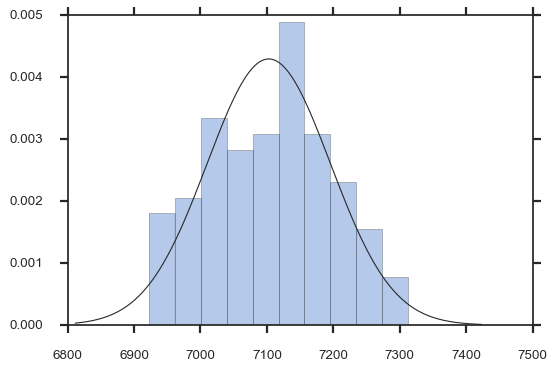

In [81]:
import seaborn as sns
%matplotlib inline
import scipy.stats as st
sns.distplot(test_df2[['size']], kde=False, fit=st.norm, bins=10)

In [82]:
z_score =(region_intersection.count() - np.mean(test_df2['size']))/np.std(test_df2['size'])
print(z_score)

32.71655099559921


In [83]:
import scipy.stats as st
st.norm.ppf(.95)
st.norm.cdf(z_score)

1.0

In [84]:
p_values = st.norm.sf(abs(z_score))
p_values

4.542105259589597e-235

In [85]:
st.ttest_1samp(a= test_df2[['size']], popmean= region_intersection.count())

Ttest_1sampResult(statistic=array([-325.52557226]), pvalue=array([  8.33999626e-152]))

In [86]:
chi2, p = st.chisquare( test_df2[['size']],region_intersection.count() )
msg = "Test Statistic: {}\np-value: {}"
print( msg.format( chi2, p ) )

Test Statistic: [ 91211.40589569]
p-value: [ 0.]


In [87]:
repeat_bed.sort().fisher(encode_bed_slop.sort(), f=1, g=assembly_path)

<FisherOutput at 4882071504>
# Number of query intervals: 594372
# Number of db intervals: 43011
# Number of overlaps: 10143
# Number of possible intervals (estimated): 2704738
# phyper(10143 - 1, 594372, 2704738 - 594372, 43011, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 10143        | 584229       |
# not in -a | 32868        | 2077498      |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	4.4246e-16	8.4222e-16	1.097

In [88]:
#pvalue <- 1-phyper(45, 92, 7518, 1329)
#pvalue = 1-stats.hypergeom.cdf(45, 7518, 92. 1329)
1-st.hypergeom.cdf(66741, 0, 594732, 33082)

0.0

In [89]:
df_reldist = pd.DataFrame(encode_bed_slop.sort().reldist(repeat_bed.sort()))
df_reldist.T

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
count,888.000,837.000,860.00,869.00,919.000,828.000,891.000,889.000,888.000,927.000,...,819.000,869.00,795.000,852.00,820.000,822.000,835.000,860.00,843.00,6.0
fraction,0.021,0.019,0.02,0.02,0.021,0.019,0.021,0.021,0.021,0.022,...,0.019,0.02,0.018,0.02,0.019,0.019,0.019,0.02,0.02,0.0
reldist,0.000,0.010,0.02,0.03,0.040,0.050,0.060,0.070,0.080,0.090,...,0.410,0.42,0.430,0.44,0.450,0.460,0.470,0.48,0.49,0.5
total,43011.000,43011.000,43011.00,43011.00,43011.000,43011.000,43011.000,43011.000,43011.000,43011.000,...,43011.000,43011.00,43011.000,43011.00,43011.000,43011.000,43011.000,43011.00,43011.00,43011.0


In [90]:
df_reldist_random = pd.DataFrame(encode_bed_slop.sort().reldist(repeat_bed.sort().shuffle(g=assembly_path, chrom=False).sort()))

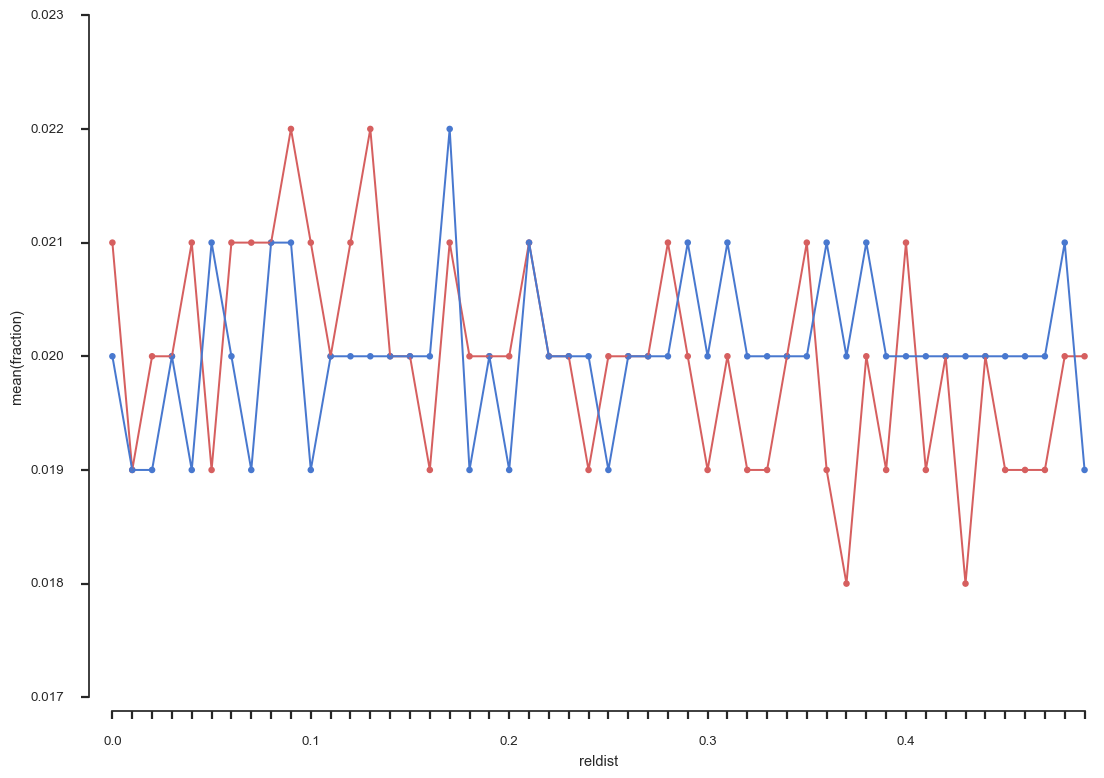

In [91]:
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="ticks", palette="muted", color_codes=True)
sns.set_context("poster", font_scale=0.6, rc={"lines.linewidth": 0.8})

g1 = sns.pointplot(x='reldist', y='fraction', data=df_reldist[0:50],  color='r')
g2 = sns.pointplot(x='reldist', y='fraction', data=df_reldist_random[0:50], color='b')

sns.despine(offset=10, trim=True)
#plot.set_yscale("log")
#df_reldist[['reldist','fraction']].plot()
for ind, label in enumerate(g1.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## Densities

In [92]:
# density
# assuming expected number of MIR-enhancers as
# average genome-wide density of enhancers (enhancers/bp) * total bp length of all MIRs

def compute_expected_number(name1_bed_df, name2_bed_df, name1, name2):
    genome_size = 3095677412
    #enhancers_bed_df['size'] = enhancers_bed_df['end'] - enhancers_bed_df['start']
    name1_density = len(name1_bed_df) /  genome_size
    name2_bed_df['size'] = name2_bed_df['end'] - name2_bed_df['start']
    name2_len = name2_bed_df['size'].sum()
    print(name1, 'density =', name1_density, '(num of intervals)/(genome bp)')
    print(name2,'length =', name2_len, 'bp')
    print('Expected number of', name2, name1, '=', int(round(name1_density * name2_len)))

In [93]:
compute_expected_number(encode_bed_df, repeat_bed_df, 'K562 enhancers', 'Sine/MIR')

K562 enhancers density = 1.3893889535541825e-05 (num of intervals)/(genome bp)
Sine/MIR length = 84720992 bp
Expected number of Sine/MIR K562 enhancers = 1177


In [107]:
genes_bed = BedTool("../download/genome/knownGene_hg19.bed")
genes_bed_df = genes_bed.to_dataframe()
chrom_list = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrX',
              'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
              'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chrY', 'chr19',
              'chr22', 'chr21']

genes_bed_df = genes_bed_df.query("chrom in @chrom_list")

In [108]:
genes_bed.count()

82960

In [109]:
compute_expected_number(genes_bed_df, repeat_bed_df, 'Genes', 'Sine/MIR')

Genes density = 2.5457109870206334e-05 (num of intervals)/(genome bp)
Sine/MIR length = 84720992 bp
Expected number of Sine/MIR Genes = 2157


In [111]:
# genic enhancers: enhancers in genic regions
genic_enhancers_bed = fantom_bed.intersect(genes_bed, f=1, u=True)

In [112]:
genic_enhancers_bed.count()

22741

In [113]:
# genic non-enhancers: genic regions without enhancers
genic_non_enhancers_bed = genes_bed.subtract(genic_enhancers_bed, A=True)

In [114]:
genic_non_enhancers_bed.intersect(genic_enhancers_bed).count()

0

In [116]:
# non-genic enhancers: enhancers outside genic regions
non_genic_enhancers_bed = fantom_bed.subtract(genes_bed, f=1, A=True)

In [117]:
non_genic_enhancers_bed.count()

20270

In [119]:
non_genic_enhancers_bed.count() + genic_enhancers_bed.count() == fantom_bed.count()

True

In [120]:
# 200 bp regions around core of enhancers
enhancers_regions_bed = encode_bed_cores.slop(g=assembly_path, b=200)

In [121]:
enhancers_regions_bed.count()

43011

In [122]:
genes_bed_df['size'] = genes_bed_df.apply(lambda row: compute_size(row), axis=1)

In [123]:
genes_bed_df[['size']].quantile(np.arange(0,1,0.1))

,size
0.0,19.0
0.1,993.6
0.2,4083.0
0.3,8054.0
0.4,13047.0
0.5,20134.0
0.6,30029.2
0.7,44468.0
0.8,71447.4
0.9,133227.0


In [124]:
def compute_density_region(bed_in_region_df, region_df):
    region_size = region_df['size'].sum()
    bed_in_region_size = bed_in_region_df['size'].sum()
    
    return bed_in_region_size / region_size

In [125]:
repeat_reg1_df = repeat_bed.intersect(genic_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [126]:
repeat_reg2_df = repeat_bed.intersect(genic_non_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [127]:
repeat_reg3_df = repeat_bed.intersect(non_genic_enhancers_bed, f=1e-09, u=True).to_dataframe()

In [128]:
repeat_reg4_df = repeat_bed.intersect(enhancers_regions_bed, f=1e-09, u=True).to_dataframe()

In [129]:
reg1_df = genic_enhancers_bed.to_dataframe()
reg2_df = genic_non_enhancers_bed.to_dataframe()
reg3_df = non_genic_enhancers_bed.to_dataframe()
reg4_df = enhancers_regions_bed.to_dataframe()

reg1_df['size'] =  reg1_df.apply(lambda row: compute_size(row), axis=1)
reg2_df['size'] =  reg2_df.apply(lambda row: compute_size(row), axis=1)
reg3_df['size'] =  reg3_df.apply(lambda row: compute_size(row), axis=1)
reg4_df['size'] =  reg4_df.apply(lambda row: compute_size(row), axis=1)

repeat_reg1_df['size'] = repeat_reg1_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg2_df['size'] = repeat_reg2_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg3_df['size'] = repeat_reg3_df.apply(lambda row: compute_size(row), axis=1)
repeat_reg4_df['size'] = repeat_reg4_df.apply(lambda row: compute_size(row), axis=1)

In [130]:
d1 = compute_density_region(repeat_reg1_df,reg1_df)
d2 = compute_density_region(repeat_reg2_df,reg2_df)
d3 = compute_density_region(repeat_reg3_df,reg3_df)
d4 = compute_density_region(repeat_reg4_df,reg4_df)

print("density of MIR in genic enhancers", d1)
print("density of MIR in genic non enhancers", d2)
print("density of MIR in non genic enhancers", d3)
print("density of MIR in enhancer regions", d4)

sum_d = d1+d2+d3+d4

print("Normalized Ratios",d1/sum_d, d2/sum_d, d3/sum_d, d4/sum_d)


density of MIR in genic enhancers 0.056922729856361244
density of MIR in genic non enhancers 0.010554416928043233
density of MIR in non genic enhancers 0.05225036904657156
density of MIR in enhancer regions 0.049385099160679825
Normalized Ratios 0.3365965919169889 0.062410583199627036 0.3089678972154125 0.29202492766797156


## Closeness Profile

In [131]:
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

def compute_centers(closeness_df):
    closeness_df['centered_locus'] = round(
        (closeness_df['end'] - closeness_df['start'])/2 
        + closeness_df['start']).astype(int)

    closeness_df['close_centered_locus'] = round(
        (closeness_df['close_end'] - closeness_df['close_start'])/2 
        + closeness_df['close_start']).astype(int)

    closeness_df['centered_distance'] = closeness_df['close_centered_locus'] - closeness_df['centered_locus'] 
    return closeness_df

def compute_closeness_df(sorted_bed, sorted_bed_with):
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                     'close_chrom', 'close_start','close_end', 
                     'close_name', 'close_score', 'close_strand', 'distance']
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    return closeness_df

def build_closeness_df(bed, bed_with):
    
    closeness_columns = ['chrom', 'start', 'end', 'name', 'score', 'strand',
                         'close_chrom', 'close_start','close_end', 
                         'close_name', 'close_score', 'close_strand', 'distance']
    
    sorted_bed = bed.sort()
    sorted_bed_with = bed_with.sort()
    
    # real on real
    closeness = sorted_bed.closest(sorted_bed_with, D='a')
    closeness_df = closeness.to_dataframe()
    closeness_df.columns = closeness_columns
    closeness_df = compute_centers(closeness_df)
    
    return closeness_df

In [132]:
fantom_bed = BedTool().from_dataframe(
    fantom_bed.to_dataframe()[['chrom', 'start', 'end', 'name', 'score', 'strand']])

In [133]:
repeat_closeness_df = build_closeness_df(fantom_bed, repeat_bed)

(-5000, 5000)

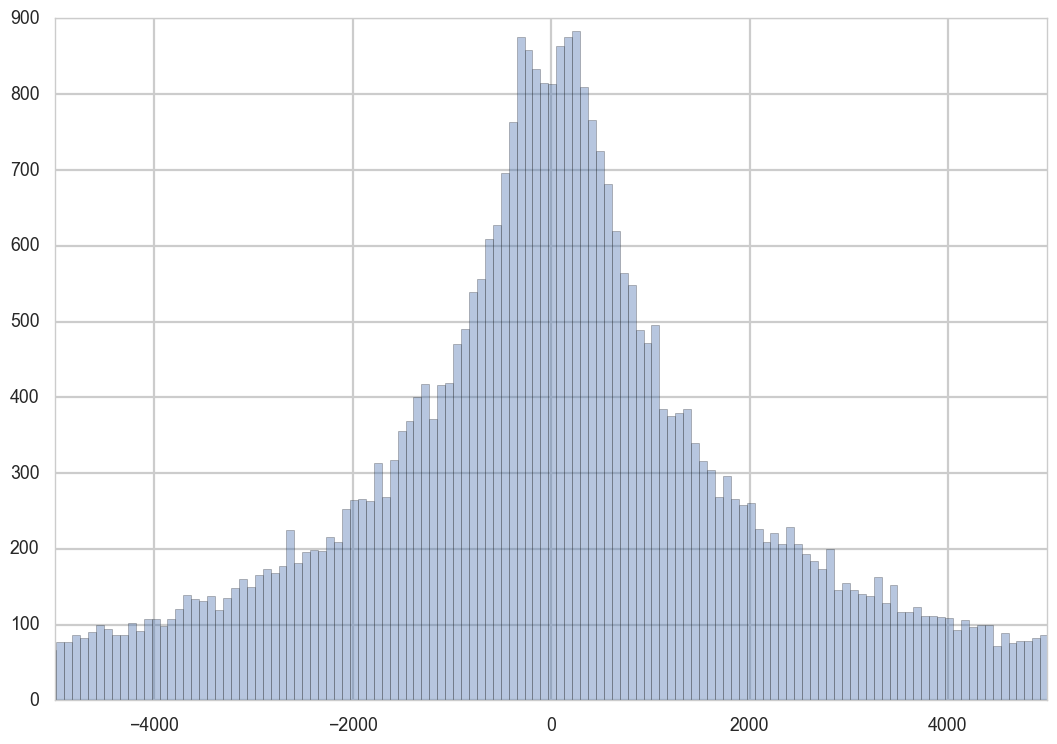

In [136]:
sns.set(style="whitegrid")
sns.set_context("poster", font_scale=0.8, rc={"lines.linewidth": 1})
g1 = sns.distplot(repeat_closeness_df[['centered_distance']], kde=False, bins=10000)
g1.set_xlim(-5000, 5000)